In [1]:
import pandas as pd
import numpy as np
%load_ext autoreload
%autoreload 2
import json
import re

In [2]:
from sklearn.feature_extraction import FeatureHasher
from sklearn.preprocessing import OneHotEncoder

In [3]:
from sklearn.metrics import precision_recall_curve
from matplotlib import pyplot as plt

In [4]:
import xgboost as xgb
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [5]:
from sklearn.metrics import log_loss, roc_auc_score, make_scorer

In [6]:
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV, train_test_split

In [7]:
from utils_preprocess import *

In [8]:
from transformation_pipeline import *

In [9]:
with open('column_types.json', 'r') as json_file:
        column_types = json.load(json_file)

In [10]:
train = pd.read_parquet("train.parquet")

In [94]:

train[:1000].to_parquet('train_test.parquet')

In [11]:
test = pd.read_parquet("test.parquet")

In [12]:
train.dropna(axis=1, how='all', inplace = True)
test.dropna(axis=1, how='all', inplace = True)

In [13]:
timestamp_columns = column_types.get('timestamp', [])
categorical_columns = column_types.get('categorical', [])
numerical_columns = column_types.get('numerical', [])
json_columns = column_types.get('aggregates', [])

## 1- Clean column names

In [19]:
train.columns = [clean_column_name(col) for col in train.columns]

In [20]:
test.columns = [clean_column_name(col) for col in train.columns]

## 2- Change data types

In [21]:
train = change_data_types(train, column_types)

In [22]:
test = change_data_types(test, column_types)

## 3- Split to train/test

## 4- Preprocessing

In [81]:
columns_to_drop = ['bid_id', 'bid_timestamp', 'user_id', "purchase_since_install", 'install_date', 'session_start_date', 'previous_session_start_date', "install_label" ]

In [82]:
train_transformed = train.drop(columns = columns_to_drop)

In [83]:
test_transformed = test.drop(columns = columns_to_drop)

In [84]:
cat_features = categorical_columns

In [85]:
list_features =['first_x_session_description', 'current_x_session_description','previous_x_session_description']

In [86]:
dict_features = ['previous_session_cpm', 'revenues', 'revenues_since_install']

In [87]:
aggregated_features = ['game_count_in_last_1_days__by_source_app',
 'game_count_in_last_7_days__by_source_app',
 'game_count_in_last_28_days__by_source_app',
 'sessions_in_last_1_days__by_source_app',
 'sessions_in_last_7_days__by_source_app',
 'sessions_in_last_28_days__by_source_app',
 'rv_watched_in_last_1_days__by_source_app',
 'rv_watched_in_last_7_days__by_source_app',
 'rv_watched_in_last_28_days__by_source_app',
 'fs_watched_in_last_1_days__by_source_app',
 'fs_watched_in_last_7_days__by_source_app',
 'fs_watched_in_last_28_days__by_source_app',
 'rv_shown_in_last_1_days__by_source_app',
 'rv_shown_in_last_7_days__by_source_app',
 'rv_shown_in_last_28_days__by_source_app',
 'fs_shown_in_last_1_days__by_source_app',
 'fs_shown_in_last_7_days__by_source_app',
 'fs_shown_in_last_28_days__by_source_app',
 'session_length_in_last_1_days__by_source_app',
 'session_length_in_last_7_days__by_source_app',
 'session_length_in_last_28_days__by_source_app',
 'game_length_in_last_1_days__by_source_app',
 'game_length_in_last_7_days__by_source_app',
 'game_length_in_last_28_days__by_source_app',
 'game_finished_count_in_last_1_days__by_source_app',
 'game_finished_count_in_last_7_days__by_source_app',
 'game_finished_count_in_last_28_days__by_source_app',
 'impression_count_in_last_1_days__by_promoted_entity',
 'impression_count_in_last_7_days__by_promoted_entity',
 'impression_count_in_last_28_days__by_promoted_entity']

In [88]:
columns_types= {"numerical_features": numerical_columns,
                "cat_features": cat_features,
                "dict_features": dict_features,
                "aggregated_features": aggregated_features,
                "list_features": list_features,
                "timestamp_features": timestamp_columns
                }

In [89]:
with open('column_types.json', 'w') as json_file:
    json.dump(column_types, json_file)

In [90]:
transformations_metadata = {
    "numerical": {
        "columns": numerical_columns,
        "transformations": []
    },
    "list_features": {
        "columns": list_features,
        "transformations": ["aggergate_impressions"]  ##
    },
    "dict_features": {
        "columns": dict_features,
        "transformations": ["expand_all_column"]  ## 
    },

     "aggregated_features": {
        "columns": aggregated_features,
        "transformations": ["expand_top_apps"]  ##
    },

    "cat_features": {
        "columns": cat_features,
        "transformations": ["encoder"]  ##""
    }
    
}
with open('transformations_metadata.json', 'w') as json_file:
    json.dump(transformations_metadata, json_file)

In [91]:


with open('function_map.json', 'w') as json_file:
    json.dump(function_map, json_file)

TypeError: Object of type ExpandDictStep is not JSON serializable

In [23]:





pipeline = TransformationPipeline()

# Set transformations metadata before adding steps
pipeline.transformations_metadata = transformations_metadata


for group_name, group_info in transformations_metadata.items():
    for transformation_name in group_info["transformations"]:
        transformation = function_map[transformation_name]
        if hasattr(transformation, "fit_transform"): 
            pipeline.add_step(
                f"{transformation_name}",
                transformation,
                group_info["columns"]
            )
        else:  # Handles custom function-based transformations
            for column in group_info["columns"]:
                pipeline.add_step(
                    f"{transformation_name}",
                    FunctionStep(transformation),
                    [column]
                )

In [31]:
# Fit and transform
train_data = pipeline.fit_transform(train_transformed)

In [32]:
# Save the pipeline and metadata
pipeline.save_pipeline("fitted_pipeline.pkl", "pipeline_metadata.json")

In [97]:
loaded_pipeline = TransformationPipeline().load_pipeline("fitted_pipeline.pkl", "pipeline_metadata.json", function_map)

In [98]:
test_data = loaded_pipeline.transform(test_transformed)

KeyboardInterrupt: 

In [35]:
all(test_data.dtypes.apply(lambda dtype: pd.api.types.is_numeric_dtype(dtype)))

True

In [38]:
train_data.to_csv("train_transformed.csv")

In [14]:
train_data = pd.read_csv("train_transformed.csv")

In [39]:
test_data.to_csv("test_transformed.csv")

In [15]:
test_data = pd.read_csv("test_transformed.csv")

## 5- Model training

In [16]:
from imblearn.over_sampling import SMOTE

In [23]:
train['hour_of_day'] = train['bid_timestamp'].dt.hour
train['day_of_week'] = train['bid_timestamp'].dt.dayofweek
train['bid_since_install'] = (train['bid_timestamp'] - train['install_date']).dt.days
train['play_time_ratio'] = train['play_time'] / train['total_time'].replace(0, np.nan)
train['game_count_time_interaction'] = train['game_count'] * train['total_time']

In [24]:
test['hour_of_day'] = test['bid_timestamp'].dt.hour
test['day_of_week'] = test['bid_timestamp'].dt.dayofweek
test['bid_since_install'] = (test['bid_timestamp'] - test['install_date']).dt.days
test['play_time_ratio'] = test['play_time'] / test['total_time'].replace(0, np.nan)
test['game_count_time_interaction'] = test['game_count'] * test['total_time']

In [25]:
merged_df = pd.merge(train_data,train[["bid_timestamp", 'hour_of_day','day_of_week','bid_since_install','play_time_ratio' ,'game_count_time_interaction']], left_index=True, right_index=True).set_index("bid_timestamp")

In [26]:
merged_test = pd.merge(test_data,test[["bid_timestamp",'hour_of_day','day_of_week','bid_since_install','play_time_ratio' ,'game_count_time_interaction']], left_index=True, right_index=True).set_index("bid_timestamp")

In [27]:
merged_df = merged_df.drop(columns = ["Unnamed: 0"])

In [28]:
merged_test = merged_test.drop(columns = ["Unnamed: 0"])

In [29]:
train_x = merged_df#.values  
train_y = train["install_label"]#.values

In [30]:
test_x = merged_test#.values  
test_y = test["install_label"]#.values

In [31]:
# Calculate the ratio of negatives to positives
negative_count = np.sum(train_y == 0)
positive_count = np.sum(train_y == 1)

ratio_of_negative_to_positive = negative_count / positive_count
ratio_of_negative_to_positive

np.float64(31.2809735941636)

In [32]:

# Initialize SMOTE
smote = SMOTE(sampling_strategy=0.15, random_state=42)

# Apply SMOTE to the training data
X_train_res, y_train_res = smote.fit_resample(train_x.fillna(0), train_y)


In [33]:
# Combine the resampled data back into a DataFrame
train_data_resampled = pd.concat([X_train_res, y_train_res], axis=1)

# Sort the resampled data by the 'bid_timestamp' column
train_data_resampled = train_data_resampled.sort_index()

In [34]:
X_train_resampled = train_data_resampled.drop(columns=['install_label'])
y_train_resampled = train_data_resampled['install_label']

In [60]:
# Define the XGBoost model
model = xgb.XGBClassifier(
    n_estimators=400,
    learning_rate=0.01,
    max_depth=6,
    objective='binary:logistic',  # For binary classification
    use_label_encoder=False,     # Avoid label encoding warning
    random_state=42,
    subsample = 0.8,
    colsample_bytree = 0.8,
    #scale_pos_weight=10,
    alpha=0.1,  # L1 regularization (Lasso)
    lambda_=1,  # L2 regularization (Ridge)
)

# Train the model
model.fit(
    X_train_resampled,
    y_train_resampled,  # Stop if performance doesn't improve
    verbose=True
)

/home/python/daftlearning/venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [00:41:23] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "lambda_", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBClassifier(alpha=0.1, base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, lambda_=1, learning_rate=0.01,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=400, n_jobs=None, ...)

In [61]:
from sklearn.isotonic import IsotonicRegression
from sklearn.metrics import brier_score_loss

In [62]:
# Step 4: Get predicted probabilities (before calibration)
train_probs = model.predict_proba(X_train_resampled)[:, 1]  # Probability for the positive class (class 1)
test_probs = model.predict_proba(test_x)[:, 1]

# Step 5: Fit an Isotonic Regression model to the predicted probabilities (on the train set)
iso_regressor = IsotonicRegression(out_of_bounds='clip')  # Clip out-of-bound predictions
iso_regressor.fit(train_probs, y_train_resampled)

# Step 6: Calibrate the predicted probabilities using Isotonic Regression
calibrated_train_probs = iso_regressor.transform(train_probs)
calibrated_test_probs = iso_regressor.transform(test_probs)

# Step 7: Evaluate the model performance before and after calibration
roc_auc_before = roc_auc_score(test_y, test_probs)
roc_auc_after = roc_auc_score(test_y, calibrated_test_probs)

brier_before = brier_score_loss(test_y, test_probs)
brier_after = brier_score_loss(test_y, calibrated_test_probs)

In [63]:
roc_auc_before

np.float64(0.6209276722339814)

In [64]:
roc_auc_after

np.float64(0.620843825923261)

In [66]:
import joblib
joblib.dump(iso_regressor, 'iso_regressor_test.pkl')

['iso_regressor_test.pkl']

In [ ]:
import joblib
joblib.dump(model, 'xgboost_model.pkl')

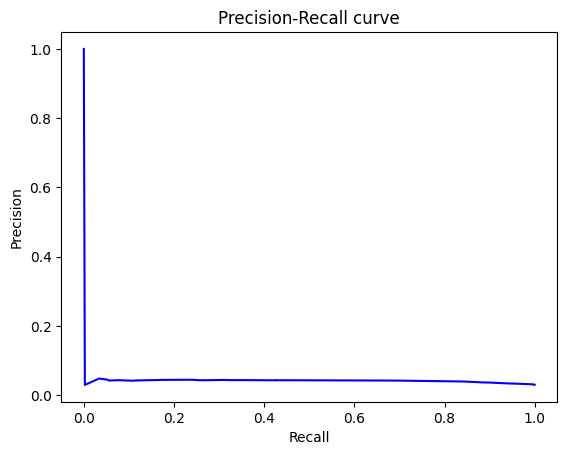

In [76]:
#y_prob = model.predict_proba(train_x)[:, 1]  # Get probability of class 1 (install)

# Calculate precision-recall curve
precision, recall, thresholds = precision_recall_curve(test_y, calibrated_test_probs)

# Plot precision-recall curve
plt.plot(recall, precision, color='b')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve')
plt.show()

In [78]:
pr_auc = auc(recall, precision)

In [79]:
pr_auc

np.float64(0.04294250856378923)

In [77]:
thresholds_1_percent = np.arange(0, 1.01, 0.01)  # Thresholds from 0 to 1 with a step of 0.01
precision_at_thresholds = []
recall_at_thresholds = []

# For each threshold, find the corresponding precision and recall
for t in thresholds_1_percent:
    # Get the index of the closest threshold in the original precision-recall curve
    idx = np.searchsorted(thresholds, t)
    precision_at_thresholds.append(precision[idx])
    recall_at_thresholds.append(recall[idx])

# Create a DataFrame to display precision and recall at each threshold
precision_recall_df = pd.DataFrame({
    'Threshold': thresholds_1_percent,
    'Precision': precision_at_thresholds,
    'Recall': recall_at_thresholds
})

# Display the table

print(precision_recall_df.set_index("Threshold").to_markdown())

|   Threshold |   Precision |     Recall |
|------------:|------------:|-----------:|
|        0    |   0.03082   | 1          |
|        0.01 |   0.0320325 | 0.991239   |
|        0.02 |   0.0337913 | 0.956846   |
|        0.03 |   0.0391214 | 0.85756    |
|        0.04 |   0.0409431 | 0.789422   |
|        0.05 |   0.0417646 | 0.743997   |
|        0.06 |   0.0427562 | 0.667424   |
|        0.07 |   0.042827  | 0.606749   |
|        0.08 |   0.0430306 | 0.558728   |
|        0.09 |   0.0431263 | 0.549643   |
|        0.1  |   0.0431021 | 0.536665   |
|        0.11 |   0.0430018 | 0.519468   |
|        0.12 |   0.0429718 | 0.507463   |
|        0.13 |   0.0429655 | 0.507138   |
|        0.14 |   0.0432709 | 0.491564   |
|        0.15 |   0.043302  | 0.48183    |
|        0.16 |   0.0433334 | 0.476963   |
|        0.17 |   0.0433347 | 0.476963   |
|        0.18 |   0.0433753 | 0.45782    |
|        0.19 |   0.0433753 | 0.45782    |
|        0.2  |   0.0435311 | 0.452953   |
|        0.

In [72]:
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(test_y, calibrated_test_probs)

# Compute AUC (Area Under the Curve)
roc_auc = auc(fpr, tpr)

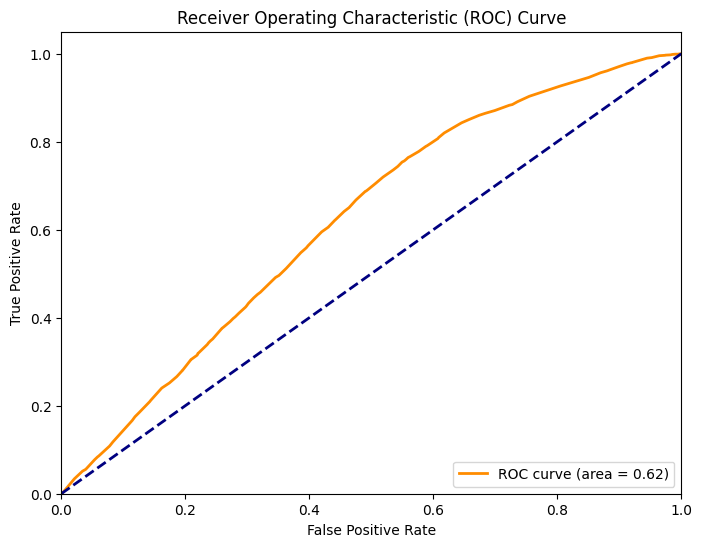

In [73]:
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # Diagonal line (random model)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()
